# 数据挖掘大作业二：关联规则挖掘


## 1. 对数据集进行处理，转换成适合关联规则挖掘的形式

该数据集是包括了许多葡萄酒的点评，本次作业打算分析红酒产地、品种的关系。

In [1]:
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import pylab
%matplotlib inline


df = pd.read_csv('assignment1/wine-reviews/winemag-data-130k-v2.csv', index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [2]:
transactions = []
for index, row in df.iterrows():
    transactions += [(row['country'], row['variety'], row['winery'])]

transactions[:20]

[('Italy', 'White Blend', 'Nicosia'),
 ('Portugal', 'Portuguese Red', 'Quinta dos Avidagos'),
 ('US', 'Pinot Gris', 'Rainstorm'),
 ('US', 'Riesling', 'St. Julian'),
 ('US', 'Pinot Noir', 'Sweet Cheeks'),
 ('Spain', 'Tempranillo-Merlot', 'Tandem'),
 ('Italy', 'Frappato', 'Terre di Giurfo'),
 ('France', 'Gewürztraminer', 'Trimbach'),
 ('Germany', 'Gewürztraminer', 'Heinz Eifel'),
 ('France', 'Pinot Gris', 'Jean-Baptiste Adam'),
 ('US', 'Cabernet Sauvignon', 'Kirkland Signature'),
 ('France', 'Gewürztraminer', 'Leon Beyer'),
 ('US', 'Cabernet Sauvignon', 'Louis M. Martini'),
 ('Italy', 'Nerello Mascalese', 'Masseria Setteporte'),
 ('US', 'Chardonnay', 'Mirassou'),
 ('Germany', 'Riesling', 'Richard Böcking'),
 ('Argentina', 'Malbec', 'Felix Lavaque'),
 ('Argentina', 'Malbec', 'Gaucho Andino'),
 ('Spain', 'Tempranillo Blend', 'Pradorey'),
 ('US', 'Meritage', 'Quiévremont')]

# 2. 寻找频繁项集

使用apriori算法，代码参考[链接](https://github.com/aknd/akapriori)。

In [3]:
from collections import defaultdict
import itertools


def apriori(transactions, support=0.1, confidence=0.8, lift=1, minlen=2, maxlen=2):
    item_2_tranidxs = defaultdict(list)
    itemset_2_tranidxs = defaultdict(list)

    for tranidx, tran in enumerate(transactions):
        for item in tran:
            item_2_tranidxs[item].append(tranidx)
            itemset_2_tranidxs[frozenset([item])].append(tranidx)

    item_2_tranidxs = dict([(k, frozenset(v)) for k, v in item_2_tranidxs.items()])
    itemset_2_tranidxs = dict([
        (k, frozenset(v)) for k, v in itemset_2_tranidxs.items()])

    tran_count = float(len(transactions))
    # print('Extracting rules in {} transactions...'.format(int(tran_count)))

    valid_items = set(item
        for item, tranidxs in item_2_tranidxs.items()
            if (len(tranidxs) / tran_count >= support))

    pivot_itemsets = [frozenset([item]) for item in valid_items]
    freqsets = []

    if minlen == 1:
        freqsets.extend(pivot_itemsets)

    for i in range(maxlen - 1):
        new_itemset_size = i + 2
        new_itemsets = []

        for pivot_itemset in pivot_itemsets:
            pivot_tranidxs = itemset_2_tranidxs[pivot_itemset]
            for item, tranidxs in item_2_tranidxs.items():
                if item not in pivot_itemset:
                    common_tranidxs = pivot_tranidxs & tranidxs
                    if len(common_tranidxs) / tran_count >= support:
                        new_itemset = frozenset(pivot_itemset | set([item]))
                        if new_itemset not in itemset_2_tranidxs:
                            new_itemsets.append(new_itemset)
                            itemset_2_tranidxs[new_itemset] = common_tranidxs

        if new_itemset_size > minlen - 1:
            freqsets.extend(new_itemsets)

        pivot_itemsets = new_itemsets

    # print('{} frequent patterns found'.format(len(freqsets)))

    for freqset in freqsets:
        for item in freqset:
            rhs = frozenset([item])
            lhs = freqset - rhs
            support_rhs = len(itemset_2_tranidxs[rhs]) / tran_count
            if len(lhs) == 0:
                lift_rhs = float(1)
                if support_rhs >= support and support_rhs > confidence and lift_rhs > lift:
                    yield (lhs, rhs, support_rhs, support_rhs, lift_rhs)
            else:
                confidence_lhs_rhs = len(itemset_2_tranidxs[freqset]) \
                    / float(len(itemset_2_tranidxs[lhs]))
                lift_lhs_rhs = confidence_lhs_rhs / support_rhs

                if confidence_lhs_rhs >= confidence and lift_lhs_rhs > lift:
                    support_lhs_rhs = len(itemset_2_tranidxs[freqset]) / tran_count
                    yield (lhs, rhs, support_lhs_rhs, confidence_lhs_rhs, lift_lhs_rhs)

频繁项集（support>0.03, confidence>0.1, lift>1）如下：

In [4]:
rules = apriori(transactions, support=0.03, confidence=0.1, lift=1)
rules_sorted = sorted(rules, key=lambda x: (x[4], x[3], x[2]), reverse=True) # ORDER BY lift DESC, confidence DESC, support DESC

for r in rules_sorted:
    print(r)


(frozenset({'Bordeaux-style Red Blend'}), frozenset({'France'}), 0.03635426364342815, 0.6832971800433839, 4.019771773295553)
(frozenset({'France'}), frozenset({'Bordeaux-style Red Blend'}), 0.03635426364342815, 0.2138686461775223, 4.019771773295553)
(frozenset({'Cabernet Sauvignon'}), frozenset({'US'}), 0.05628178593686284, 0.7722761824324325, 1.841580575864628)
(frozenset({'US'}), frozenset({'Cabernet Sauvignon'}), 0.05628178593686284, 0.13421033318655512, 1.841580575864628)
(frozenset({'Pinot Noir'}), frozenset({'US'}), 0.07605542774926714, 0.7448010849909584, 1.7760630745882846)
(frozenset({'US'}), frozenset({'Pinot Noir'}), 0.07605542774926714, 0.18136283575517392, 1.7760630745882844)
(frozenset({'Chardonnay'}), frozenset({'US'}), 0.052327057574381976, 0.5786607674636263, 1.3798825518863749)
(frozenset({'US'}), frozenset({'Chardonnay'}), 0.052327057574381976, 0.12477983267283135, 1.3798825518863749)


## 3. 导出关联规则及其支持度，置信度

In [5]:
import csv 

with open('result.csv', 'wt') as f:
    f_csv = csv.writer(f, delimiter=',')
    f_csv.writerow(['rule', 'sup', 'conf', 'lift'])
    for r in rules_sorted:
        f_csv.writerow([f'{str(list(r[0])[0])} => {str(list(r[1])[0])}', r[2], r[3], r[4]])

pd.read_csv('result.csv')


,rule,sup,conf,lift
0,Bordeaux-style Red Blend => France,0.036354,0.683297,4.019772
1,France => Bordeaux-style Red Blend,0.036354,0.213869,4.019772
2,Cabernet Sauvignon => US,0.056282,0.772276,1.841581
3,US => Cabernet Sauvignon,0.056282,0.134210,1.841581
4,Pinot Noir => US,0.076055,0.744801,1.776063
5,US => Pinot Noir,0.076055,0.181363,1.776063
6,Chardonnay => US,0.052327,0.578661,1.379883
7,US => Chardonnay,0.052327,0.124780,1.379883


## 4. 对规则进行评价，使用Lift， Kulc

由于上文已经计算了Lift，这里再计算一下Kulc。

In [6]:
res = []
for r in rules_sorted:
    conf1 = r[3]
    for r2 in rules_sorted:
        if r2[0] == r[1] and r2[1] == r[0]:
            conf2 = r2[3]
    kulc = (conf1 + conf2) / 2
    res.append(kulc)

res

[0.4485829131104531,
 0.4485829131104531,
 0.4532432578094938,
 0.4532432578094938,
 0.46308196037306615,
 0.46308196037306615,
 0.3517203000682288,
 0.3517203000682288]

## 5. 对挖掘结果进行可视化展示

这里以Bordeaux-style Red Blend => France为例。

Bordeaux-style Red Blend这个品种的葡萄酒基本上产自法国，那么我们就来检验一下：



In [7]:
df[df['variety'] == 'Bordeaux-style Red Blend'].sample(20)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
109896,France,"Named after the Swedish royal family, this est...",NaN,89,NaN,Bordeaux,Haut-Médoc,NaN,Roger Voss,@vossroger,Château Bernadotte 2013 Haut-Médoc,Bordeaux-style Red Blend,Château Bernadotte
31828,France,"Ripe fruit, juicy acidity and a fine balance o...",Boha,90,17.0,Bordeaux,Blaye Côtes de Bordeaux,NaN,Roger Voss,@vossroger,Château Magdeleine Bouhou 2015 Boha (Blaye Cô...,Bordeaux-style Red Blend,Château Magdeleine Bouhou
64213,France,Wood and smoke aromas precede ripe and dusty t...,Famille Lapalu,86,10.0,Bordeaux,Médoc,NaN,Roger Voss,@vossroger,Domaines Lapalu 2008 Famille Lapalu (Médoc),Bordeaux-style Red Blend,Domaines Lapalu
116444,France,"This is rounded, with its ripe fruit dominatin...",Cuvée Prestige,87,14.0,Bordeaux,Bordeaux Supérieur,NaN,Roger Voss,@vossroger,Château de Cornemps 2009 Cuvée Prestige (Bord...,Bordeaux-style Red Blend,Château de Cornemps
77402,France,This wine is firm with plenty of structured ta...,NaN,93,NaN,Bordeaux,Margaux,NaN,Roger Voss,@vossroger,Château Giscours 2013 Margaux,Bordeaux-style Red Blend,Château Giscours
86644,France,"This ripe, bold and generous Gonfrier Frères w...",NaN,89,14.0,Bordeaux,Bordeaux,NaN,Roger Voss,@vossroger,Château Tassin 2015 Bordeaux,Bordeaux-style Red Blend,Château Tassin
36585,US,This wine is made from a majority of Cabernet ...,Winston Hill,92,150.0,California,Rutherford,Napa,Virginie Boone,@vboone,Frank Family 2012 Winston Hill Red (Rutherford),Bordeaux-style Red Blend,Frank Family
51398,US,"Full bodied, with structured tannins and brigh...",New World Red,85,34.0,Virginia,Monticello,NaN,NaN,NaN,Kluge Estate 2009 New World Red Red (Monticello),Bordeaux-style Red Blend,Kluge Estate
103898,US,"A proprietary blend of 36% Cabernet Sauvignon,...",Contrarian,91,135.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Blackbird Vineyards 2013 Contrarian Red (Napa ...,Bordeaux-style Red Blend,Blackbird Vineyards
78741,France,"This is a firmly structured wine, solid with f...",NaN,92,NaN,Bordeaux,Pessac-Léognan,NaN,Roger Voss,@vossroger,Château Carbonnieux 2014 Pessac-Léognan,Bordeaux-style Red Blend,Château Carbonnieux


可以看出，法国的确比较多。那么再绘制一个直方图

的确基本上都是法国的。

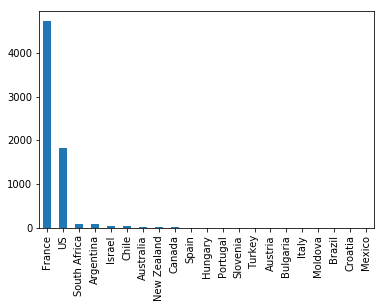

In [9]:
df[df['variety'] == 'Bordeaux-style Red Blend']['country'].value_counts().plot(kind='bar')